### This notebook trains a N2V network in the first step and then finetunes the denoising network for segmentation using the denoised images as input.

In [1]:
# We import all our dependencies.
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../')
from voidseg.models import Seg, SegConfig
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from voidseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from voidseg.utils.seg_utils import *
from n2v.utils.n2v_utils import manipulate_val_data
from voidseg.utils.compute_precision_threshold import compute_threshold, precision
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from scipy import ndimage
import tensorflow as tf
import keras.backend as K
import urllib
import os
import zipfile
from tqdm import tqdm, tqdm_notebook

Using TensorFlow backend.


### Download BBBC004 data.

This data is available from the Broad Bioimage Benchmark Collection linked [here](https://data.broadinstitute.org/bbbc/BBBC004/)  and consists of synthetic nuclei images. Since the data is synthetic, perfect GT labels are available by construction. Here we use only those images which have been generated with an overlap probability of 0. We extracted 880 image patches (of size 128 × 128) from the training set and added Gaussian noise with mean 0 and sigma = 150 (n150) and 200 (n200). This notebook shows results for n200 images.

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BBBC004.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://owncloud.mpi-cbg.de/index.php/s/zlgcEjqBbK3jcEs/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

The downloaded data is in `npz` format and the cell below extracts the training, validation and test data as numpy arrays

In [3]:
trainval_data =  np.load('data/BBBC/train_data/bbbc004_TrainVal200.npz')
test_data =  np.load('data/BBBC/test_data/bbbc004_Test200.npz', allow_pickle=True)
train_images = trainval_data['X_train']
val_images = trainval_data['X_val']
test_images = test_data['X_test']

train_masks = trainval_data['Y_train']
val_masks = trainval_data['Y_val']
test_masks = test_data['Y_test']

In [4]:
print("Shape of train_images: ", train_images.shape, ", Shape of train_masks: ", train_masks.shape)
print("Shape of val_images: ", val_images.shape, ", Shape of val_masks: ", val_masks.shape)
print("Shape of test_images: ", test_images.shape, ", Shape of test_masks: ", test_masks.shape)

Shape of train_images:  (748, 128, 128) , Shape of train_masks:  (748, 128, 128)
Shape of val_images:  (132, 128, 128) , Shape of val_masks:  (132, 128, 128)
Shape of test_images:  (220, 128, 128) , Shape of test_masks:  (220, 128, 128)


### Data preparation for training a N2V network

Since, we can use all the noisy data for training N2V network, we combine the noisy train_images and test_images and use them as input to the N2V network.

In [5]:
X, Y = combine_train_test_data(X_train=train_images,Y_train=train_masks,X_test=test_images,Y_test=test_masks)
print("Combined Dataset Shape", X.shape)

Combined Dataset Shape (968, 128, 128)


In [6]:
X_val = val_images
Y_val = val_masks

Next, we shuffle the training pairs and augment the training and validation data.

In [7]:
random_seed = 1 # Seed to shuffle training data (annotated GT and raw image pairs)

X, Y = shuffle_train_data(X, Y, random_seed = random_seed)
print("Training Data \n..................")
X, Y = augment_data(X, Y)
print("\n")
print("Validation Data \n..................")
X_val, Y_val = augment_data(X_val, Y_val)

Training Data 
..................
Raw image size after augmentation (7744, 128, 128)
Mask size after augmentation (7744, 128, 128)


Validation Data 
..................
Raw image size after augmentation (1056, 128, 128)
Mask size after augmentation (1056, 128, 128)


In [8]:
# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)

(7744, 128, 128, 1)
(1056, 128, 128, 1)


Let's look at one of our training and validation patches.

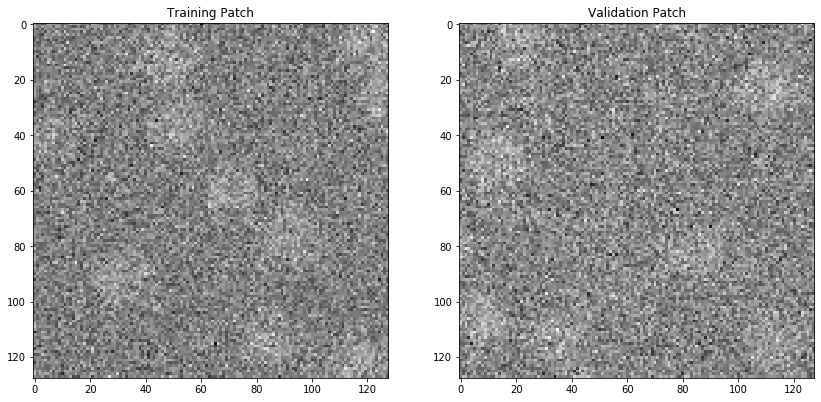

In [9]:
sl=0
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[sl,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[sl,...,0], cmap='gray')
plt.title('Validation Patch');

### Configure N2V Network

The data preparation for training a denoising N2V network is now done. Next, we configure N2V network by specifying `N2VConfig` parameters.

In [10]:
config = N2VConfig(X, unet_kern_size=3, n_channel_out=1,train_steps_per_epoch=400, train_epochs=50, 
                   train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.784, n2v_patch_shape=(64, 64),
                   unet_n_first = 32,
                   unet_residual = False,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, unet_n_depth=3)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['65.11411305062629'],
 'stds': ['204.61227284115375'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 50,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.784,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'probabilistic': False}

In [11]:
# a name used to identify the model
model_name = 'n200_denoising'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

Now, we begin training the denoising N2V model. In case, a trained model is available, that model is loaded else a new model is trained.

In [12]:
# We are ready to start training now.
query_weightpath = os.getcwd()+"/models/"+model_name
weights_present = False
for file in os.listdir(query_weightpath):
    if(file == "weights_best.h5"):
        print("Found weights of a trained N2V network, loading it for prediction!")
        weights_present = True 
        break 
if(weights_present):
    model.load_weights("weights_best.h5")
else:
    history = model.train(X, X_val)

Found weights of a trained N2V network, loading it for prediction!


Here, we predict denoised images which are subsequently used as input for segmentation step.

In [13]:
pred_train = []
pred_val = []
pred_test = []

for i in tqdm_notebook(range(train_images.shape[0])):
    p_ = model.predict(train_images[i].astype(np.float32), 'YX');
    pred_train.append(p_)

train_images_denoised = np.array(pred_train)

for i in tqdm_notebook(range(val_images.shape[0])):
    p_ = model.predict(val_images[i].astype(np.float32), 'YX');
    pred_val.append(p_)

val_images_denoised = np.array(pred_val)

for i in tqdm_notebook(range(test_images.shape[0])):
    p_ = model.predict(test_images[i].astype(np.float32), 'YX');
    pred_test.append(p_)

test_images_denoised = np.array(pred_test)

In [14]:
print("Shape of denoised train_images: ", train_images_denoised.shape, ", Shape of train_masks: ", train_masks.shape)
print("Shape of denoised val_images: ", val_images_denoised.shape, ", Shape of val_masks: ", val_masks.shape)
print("Shape of denoised test_images: ", test_images_denoised.shape, ", Shape of test_masks: ", test_masks.shape)

Shape of denoised train_images:  (748, 128, 128) , Shape of train_masks:  (748, 128, 128)
Shape of denoised val_images:  (132, 128, 128) , Shape of val_masks:  (132, 128, 128)
Shape of denoised test_images:  (220, 128, 128) , Shape of test_masks:  (220, 128, 128)


### Data preparation for segmentation step

Next, we normalize all raw data with the mean and std (standard deviation) of the raw `train_images`. Then, we shuffle the raw training images and the correponding Ground Truth (GT). Lastly, we fractionate the training pairs of raw images and corresponding GT to realize the case where not enough annotated, training data is available. For this fractionation, please specify `fraction` parameter below. It should be between 0 (exclusive) and 100 (inclusive).

In [15]:
fraction = 2 # Fraction of annotated GT and raw image pairs to use during training. 
random_seed = 1 # Seed to shuffle training data (annotated GT and raw image pairs).


assert 0 <fraction<= 100, "Fraction should be between 0 and 100"
mean, std = np.mean(train_images_denoised), np.std(train_images_denoised)

X_normalized = normalize(train_images_denoised, mean, std)
X_val_normalized = normalize(val_images_denoised, mean, std)
X_test_normalized = normalize(test_images_denoised, mean, std)

X_shuffled, Y_shuffled = shuffle_train_data(X_normalized, train_masks, random_seed = random_seed)
X_frac, Y_frac = fractionate_train_data(X_shuffled, Y_shuffled, fraction = fraction)
print("Training Data \n..................")
X, Y_train_masks = augment_data(X_frac, Y_frac)
print("\n")
print("Validation Data \n..................")
X_val, Y_val_masks = augment_data(X_val_normalized, val_masks)

Training Data 
..................
Raw image size after augmentation (120, 128, 128)
Mask size after augmentation (120, 128, 128)


Validation Data 
..................
Raw image size after augmentation (1056, 128, 128)
Mask size after augmentation (1056, 128, 128)


Next, we do a one-hot encoding of training and validation labels for training a 3-class U-Net. One-hot encoding will extract three channels from each labelled image, where the channels correspond to background, foreground and border.

In [16]:
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print(X.shape, Y.shape)
print(X_val.shape, Y_val.shape)

(120, 128, 128, 1) (120, 128, 128, 3)
(1056, 128, 128, 1) (1056, 128, 128, 3)


Let's look at one of our validation patches.

Text(0.5, 1.0, '1-hot encoded border')

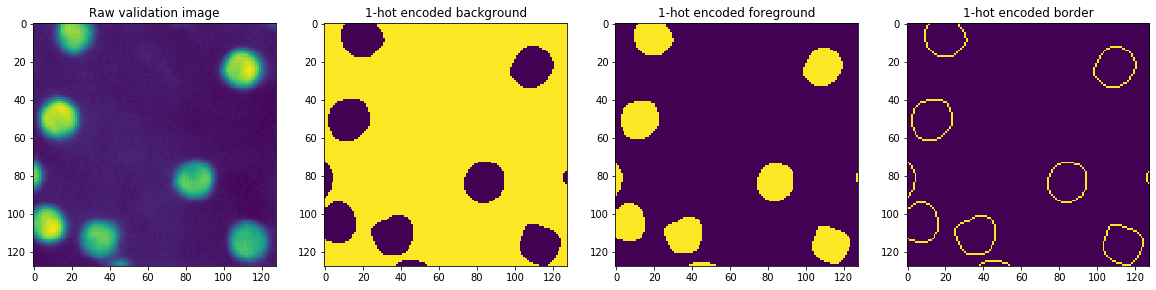

In [17]:
sl=0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X_val[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y_val[sl,...,0])
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y_val[sl,...,1])
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y_val[sl,...,2])
plt.title('1-hot encoded border')

### Configure Segmentation Network

The data preparation for segmentation is now done. Next, we configure a segmentation network by specifying `SegConfig` parameters. For example, one can increase `train_epochs` to get even better results at the expense of a longer computation. (This holds usually true for a large `fraction`.)

In [25]:
relative_weights = [1.0,1.0,5.0] # Relative weight of background, foreground and border class for training

config = SegConfig(X, unet_kern_size=3, relative_weights = relative_weights,
                   train_steps_per_epoch=400, train_epochs=3, batch_norm=True, 
                   train_batch_size=128, unet_n_first = 32, unet_n_depth=3)

# Let's look at the parameters stored in the config-object.
# a name used to identify the model
model_name = 'seg_finetune_sequential'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
seg_model = Seg(config, model_name, basedir=basedir)
vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 3,
 'train_loss': 'seg',
 'unet_n_depth': 3,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 3,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True}

##### For finetuning, we initialize segmentation network with the best weights of the denoising N2V network trained above.

In [26]:
ft_layers = seg_model.keras_model.layers
n2v_layers = model.keras_model.layers

for i in range(0, len(n2v_layers)-2):
    ft_layers[i].set_weights(n2v_layers[i].get_weights())

for l in seg_model.keras_model.layers:
    l.trainable=True

Now, we begin training the model for segmentation.

In [27]:
seg_model.train(X, Y, (X_val, Y_val))

Epoch 1/3
400/400 [==============================] - 126s 316ms/step - loss: 0.2728 - seg_crossentropy: 0.2728 - val_loss: 0.3040 - val_seg_crossentropy: 0.3040
Epoch 2/3
400/400 [==============================] - 122s 306ms/step - loss: 0.0465 - seg_crossentropy: 0.0465 - val_loss: 0.4492 - val_seg_crossentropy: 0.4492
Epoch 3/3
400/400 [==============================] - 122s 306ms/step - loss: 0.0257 - seg_crossentropy: 0.0257 - val_loss: 0.5707 - val_seg_crossentropy: 0.5707

Loading network weights from 'weights_best.h5'.


### Computing the best threshold on validation images (to maximize Average Precision score). The threshold so obtained will be used to get hard masks from probability images to be predicted on test images.

In [28]:
threshold=seg_model.optimize_thresholds(X_val_normalized.astype(np.float32), val_masks)

Computing best threshold: 


Precision-Score for threshold = 0.10 is 0.3080
Precision-Score for threshold = 0.15 is 0.4503
Precision-Score for threshold = 0.20 is 0.5936
Precision-Score for threshold = 0.25 is 0.7151
Precision-Score for threshold = 0.30 is 0.7645
Precision-Score for threshold = 0.35 is 0.7838
Precision-Score for threshold = 0.40 is 0.7981
Precision-Score for threshold = 0.45 is 0.8005
Precision-Score for threshold = 0.50 is 0.8049
Precision-Score for threshold = 0.55 is 0.8076
Precision-Score for threshold = 0.60 is 0.7990
Precision-Score for threshold = 0.65 is 0.7960
Precision-Score for threshold = 0.70 is 0.7886
Precision-Score for threshold = 0.75 is 0.7839
Precision-Score for threshold = 0.80 is 0.7851
Precision-Score for threshold = 0.85 is 0.7811
Precision-Score for threshold = 0.90 is 0.7681
Precision-Score for threshold = 0.95 is 0.7205
Precision-Score for threshold = 1.00 is 0.0000



### Prediction on test images to get segmentation result

In [29]:
predicted_images, precision_result=seg_model.predict_label_masks(X_test_normalized, test_masks, threshold)
print("Average precision over all test images at IOU = 0.5: ", precision_result)

Average precision over all test images at IOU = 0.5:  0.7920402324947781


Text(0.5, 1.0, 'Ground Truth')

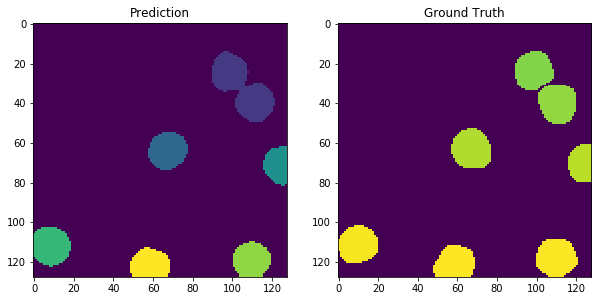

In [30]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(predicted_images[22])
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test_masks[22])
plt.title('Ground Truth')